<h1> Create a Task-Specific BERT Model </h1>

This Jupyter notebook example walks through the process of creating a SAS Viya BERT model capable of performing a single-sentence classification task in a step-by-step fashion.  

First, [define and configure your computing environment and tools](#Define-and-Configure-the-Computing-Environment): 

* [Import Python Function Packages](#Import-Python-Packages)
* [Specify Operating System Parameters](#Specify-OS-Parms)
* [Connect to the SAS Viya Server](#Connect-to-SAS-Viya-Server)

Then, [create a BERT model](#BERT-Model-Process):

* [Define Example Task Parameters](#Define-Example-Parms)
* [Create SAS Viya Version of BERT Model](#Create-Viya-BERT)
* [Compile the BERT Classification Model](#Compile-BERT)
* [Attach the BERT Model Parameters](#Attach-BERT-Parms)

<h2> Client and Server Terminology in this Example</h2>

SAS Viya literature and technical documentation often refers to client and server entities. In this example, the client is the computer that runs the Jupyter notebook, and the server is the computer that runs the SAS Viya server. These two computers might (or might not) use the same operating system, and might (or might not) have access to a common file system.

System topologies vary: the client and server operations in this example might be different in other environments.  This example assumes that the client and server do not have access to a common file system. Therefore, you will need to copy or transfer files between client and server. This Jupyter notebook provides comments in cells that indicate when a given file should be moved from the client to the server.

<a id="Define-and-Configure-the-Computing-Environment"></a>
<h2> Define and Configure the Computing Environment </h2>

<a id="Import-Python-Packages"></a>

Begin preparing the computing environment by importing the necessary Python function packages:

<h3> Import Python Function Packages </h3>

In [1]:
# Import necessary Python function packages

# Import sys and os packages
import sys
import os

# Import Numpy scientific computing and 
# Pandas data structures libraries
import numpy as np
import pandas as pd

# Import BERT model class
from dlpy.transformers.bert_model import BERT_Model

<a id="Specify-Client-Parms"></a>
<h3> Specify Client Parameters </h3>

This section of code configures the notebook for use with Linux or Windows SAS Viya clients.

In [2]:
# Generalize the example Jupyter notebook so it can be used with Linux and Windows Viya clients

# Linux client parameters
if sys.platform.startswith('linux'):

    # path to HuggingFace cache directory
    cache_dir='/your-environment-path/to-cache-dir'   
    
# Windows client parameters    
elif sys.platform.startswith('win'):
    
    # path to HuggingFace cache directory
    cache_dir='Drive:\\your-path\\to-cache-dir'

# Unsupported operating system client    
else:
    raise ValueError('Unrecognized operating system')

<a id="Connect-to-SAS-Viya-Server"></a>
<h3> Connect to the SAS Viya Server </h3>

This section of code invokes the SAS Wrapper for Analytics Transfer (SWAT), configures the Python matplotlib utility for Jupyter notebook output display, connects to a SAS Viya server, and loads the SAS CAS DeepLearn action set into memory.

In [3]:
# The SAS Scripting Wrapper for Analytic Transfer (SWAT)
# is a module used to connect to a SAS Viya server.
from swat import * 

# Configure the Python matplotlib utility to display output in 
# Jupyter notebook cells.
%matplotlib inline

# Specify the name of your SAS Viya host
host = 'your-host-name'

# Specify your installation's port ID and UserID parameters.
s = CAS(host, 99999, 'userID')

# load the SAS Viya Deep Learning Action Sets
s.loadactionset('deepLearn')

NOTE: Added action set 'deepLearn'.


[actionset]

 'deepLearn'

+ Elapsed: 0.0103s, user: 0.00251s, sys: 0.00771s, mem: 0.205mb

<a id="BERT-Model-Process"></a>
<h2> Create a BERT Model </h2>

Use the following steps to create a SAS BERT classification model and import pre-trained parameters:

* [Set Example Task Parameters](#Set-Example-Parms)
* [Define SAS Viya Version of BERT Model](#Define-Viya-BERT)
* [Compile the BERT Classification Model](#Compile-BERT)
* [Attach the BERT Model Parameters](#Attach-BERT-Parms)

<a id="Set-Example-Parms"></a>
<h3> Set the Example Task Parameters </h3>

This example assumes that the task is a binary single-sentence classification problem. This task has only a single target variable. The final classification layer needs predictions for two classes. 

Six of the twelve encoder layers of the BERT<sub>base</sub> model described in the paper [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805) (Devlin, Chang, Lee, and Toutanova) are used. 

The following code specifies the example task parameters:

In [4]:
# Task parameters for BERT model

# Final classification layer number of class predictions
n_classes = 2

# Number of BERT encoder layers used
num_encoder_layers = 6

# Number of target variables
num_tgt_var = 1

<a id="Define-Viya-BERT"></a>
<h3> Define SAS Viya Version of BERT Model </h3>

First, create an instance of the ``BERT_Model`` class.  This class uses an instance of the ``bert-base-uncased`` model from the [HuggingFace](https://huggingface.co/transformers/installation.html) repository to build the SAS Viya BERT model.  The code in the notebook cell below assumes that you have already run the following code to download the necessary JSON files (see [pre-trained models](https://huggingface.co/transformers/pretrained_models.html)) to your local cache directory:

``model = BertModel.from_pretrained('bert-base-uncased',
                                    cache_dir=/path-to/your-cache-directory
                                   )``

When the ``BERT_Model`` class defines a new BERT model, it also prepares the embedding table that is needed to specify the token, position, and segment inputs for the BERT encoder layers.  

In the following code block, note that verbose output is enabled. Verbose output provides additional feedback for the start, progress, and completion of some internal computation operations that are not typically surfaced. The additional process information is useful as a "heartbeat" indicator (*the computation is still processing*), because some internal BERT tasks for large models can require large amounts of time to complete.

**Note:** The new ``bert`` object is a fully functional SAS DLPy model object.  This means that you can train, score, and evaluate the BERT model just as you would any other DLPy model object.  

In [5]:
# Instantiate a version of the HuggingFace BERT model
huggingface_name = 'bert-base-uncased'

# SAS DLPy BERT_Model function specifications.
# The parameter specifications use variable names
# that were declared in earlier example code blocks.
bert = BERT_Model(s,
                  cache_dir,
                  huggingface_name,
                  n_classes,
                  num_hidden_layers = num_encoder_layers,
                  # Enable verbose output
                  verbose=True)

NOTE: loading base BERT model bert-base-uncased ...
NOTE: base BERT model loaded.
NOTE: loading BERT embedding table ... 
NOTE: BERT embedding table loaded.


<a id="Compile-BERT-Model"></a>

<h3> Compile the BERT Classification Model </h3>

We exploit the functional API approach using SAS DLPy to create a BERT model terminated in a classification head. This step maps the layer definitions from the HuggingFace BERT model to equivalent SAS Deep Learning layers.  Given these SAS layer definitions, a SAS equivalent BERT model is created and all layers are connected.  

**Note:** So far, we have not assigned any model parameters. Model paramters will be assigned after the BERT model is compiled based on the HDF5 file generated as part of this step (``bert-base-uncased.kerasmodel.h5``)

In [6]:
# Compile the BERT Model
bert.compile(num_target_var=num_tgt_var)

NOTE: HDF5 file is Drive:\path-to-local-cache-dir\bert-base-uncased.kerasmodel.h5
NOTE: Model compiled successfully.


<a id="Summarize-BERT-Model"></a>
<h3> Summarize the Compiled BERT Classification Model (optional) </h3>

The following code is an optional step that displays a summary of the BERT classification model architecture:

In [7]:
# Display BERT model architecture summary:
bert.print_summary()

,Layer Id,Layer,Type,Activation,Output Size
0,0,token_input,input,None,768
1,1,position_input,input,None,768
2,2,segment_input,input,None,768
3,3,embedding_sum,residual,Identity,768
4,4,embedding_ln,layernorm,Identity,768
5,5,encoder0_mha,mhattention,Auto,768
6,6,encoder0_sum1,residual,Identity,768
7,7,encoder0_ln1,layernorm,Identity,768
8,8,encoder0_intm_dense,fc,Gelu,3072
9,9,encoder0_final_dense,fc,Identity,768


<a id="Visualize-BERT-Model"></a>
<h3> Visualize the Compiled Bert Classification Model </h3>

The following code is an optional step that displays a plot of the BERT classification model:

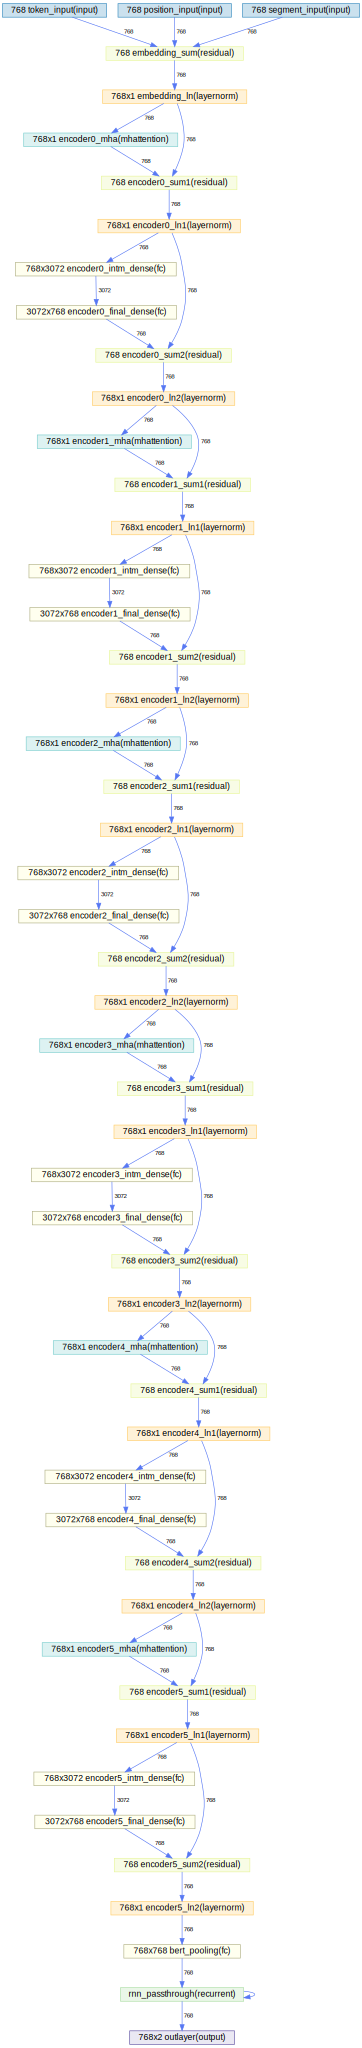

In [8]:
# Display DAG plot of BERT network
bert.plot_network()

<a id="Attach-BERT-Parms"></a>
<h2> Attach BERT Model Parameters </h2>

After compiling the BERT classification model, it is time to attach the base BERT model parameters, as well as randomly initialized parameters for the model's classification head.  The code below specifies that the base BERT model layers should not be frozen when training (``freeze_base_model=False``), so all model layers will be updated when fine-tuning the model.  

If you choose to specify ``freeze_base_model=True``, then only the final classification layer in the BERT model will be trained.  The parameters for all other layers will be frozen.

You must manually copy the file *bert-base-uncased.kerasmodel.h5* from your client to your server prior before you can run the code that follows.  You must also provide the fully qualified file name on the server when you invoke the ``load_weights()`` function.  

The fully-qualified client file name is displayed in the output cell after a successful BERT model compile. The file name is part of the output message: 

``NOTE: HDF5 file is Drive:\path-to-local-cache-dir\bert-base-uncased.kerasmodel.h5.``

In [9]:
# Load and attach the BERT model parameters
bert.load_weights('/path-to-server-directory/bert-base-uncased.kerasmodel.h5', 
                  num_target_var=num_tgt_var, 
                  # Do not freeze base model weights.
                  # Allow layer updates with model tuning.
                  freeze_base_model=False
                 )

NOTE: Model weights attached successfully!


When the cell above completes successfully, you will have a BERT Classification model ready for fine-tuning (training) on a particular classification problem.